In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal,stats,interpolate
from biosppy.signals import ecg,resp,eda,eeg
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
def reduce_mem_usage(df):
    # Function to reduce memory usage of a pandas dataframe
    # https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    return df

# Reading train and test data

In [3]:
df_train = dd.read_csv('train.csv')
df_train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [4]:
df_test = dd.read_csv('test.csv')
df_test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


# Preprocessing

We will be doing label encoding for target classes, to represent them as integers

In [5]:
event_mapping = {'A': 0, 'C': 1, 'D': 2, 'B': 3}
df_train['event'] = df_train['event'].map(event_mapping)

The column 'experiment' is also needed to be represented as a numerical value, so that we can identify the data belonging to a particular pilot in a particular experiment

In [6]:
exp_mapping = {'CA':0, 'DA':1, 'SS':2, 'LOFT':3}
df_train['experiment'] = df_train['experiment'].map(exp_mapping)
df_test['experiment'] = df_test['experiment'].map(exp_mapping)

We will be creating a new column 'pilot' which will be a numerical representation of the combination of 'crew', 'experiment' and 'seat' columns

In [7]:
df_train['pilot'] = df_train['crew'] * 100 + df_train['experiment'] * 10 + df_train['seat']
train_pilots = [pilot for pilot in df_train['pilot'].unique()]
df_train = df_train.compute()

df_test['pilot'] = df_test['crew'] * 100 + df_test['experiment'] * 10 + df_test['seat']
test_pilots = [pilot for pilot in df_test['pilot'].unique()]
df_test = df_test.compute()

# Featurization

## Declaration of global variables

In [8]:
FS = 256 # Sampling frequency
EEG_SIGNAL_NAMES = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 
                    'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 
                    'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

## Featurization of ECG and R signals

In [9]:
def get_ecg_r_features(pilot, train=True):
    # Function to generate heart rate and respiration rate feature values
    if train:
        pilot_data = df_train.loc[df_train['pilot'] == pilot]
    else:
        pilot_data = df_test.loc[df_test['pilot'] == pilot]
    pilot_data = pilot_data.iloc[pilot_data['time'].argsort()]
    pilot_data.reset_index(drop=True, inplace=True)
    N = len(pilot_data)

    new_pilot_data = pd.DataFrame()
    if train:
        new_pilot_data['id'] = [str(pilot) + "_" + str(i) for i in pilot_data.index.values]
    else:
        new_pilot_data['id'] = pilot_data['id']
    new_pilot_data['crew'] = pilot_data['crew']
    new_pilot_data['seat'] = pilot_data['seat']
    new_pilot_data['time'] = pilot_data['time']
    new_pilot_data['ecg'] = pilot_data['ecg']
    new_pilot_data['r'] = pilot_data['r']
    if all(v==0 for v in pilot_data['ecg'].values):
        new_pilot_data['heart_rate'] = [np.nan] * N
        new_pilot_data['heart_rate_diff'] = [np.nan] * N
        new_pilot_data['resp_rate'] = [np.nan] * N
        new_pilot_data['resp_rate_diff'] = [np.nan] * N
    else:
        ts,filtered,rpeaks,templates_ts,templates,heart_rate_ts,heart_rate = ecg.ecg(signal=pilot_data['ecg'].values, sampling_rate=256, show=False)
        f = interpolate.interp1d(heart_rate_ts, heart_rate, kind='cubic', fill_value='extrapolate')
        new_pilot_data['heart_rate'] = f(pilot_data['time'].values)
        new_pilot_data['heart_rate_diff'] = new_pilot_data['heart_rate'].diff().fillna(0)
        
        #https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy-signals-resp
        ts, filtered, zeros, resp_rate_ts, resp_rate_samples = resp.resp(signal=pilot_data['r'].values, sampling_rate=FS, show=False)
        #The respiration rate will be given as samples at different points from the above line. We can extrapolate these samples to fit the whole data
        f = interpolate.interp1d(resp_rate_ts, resp_rate_samples, kind='cubic', fill_value='extrapolate')
        new_pilot_data['resp_rate'] = f(pilot_data['time'].values)
        new_pilot_data['resp_rate_diff'] = new_pilot_data['resp_rate'].diff().fillna(0)
    return new_pilot_data

## Featurization of GSR signal

In [10]:
def get_gsr_features(pilot, train=True):
    # Function to generate GSR features
    if train:
        pilot_data = df_train.loc[df_train['pilot'] == pilot]
    else:
        pilot_data = df_test.loc[df_test['pilot'] == pilot]
    pilot_data = pilot_data.iloc[pilot_data['time'].argsort()]
    pilot_data.reset_index(drop=True, inplace=True)
    N = len(pilot_data)
    
    new_pilot_data = pd.DataFrame()
    if train:
        new_pilot_data['id'] = [str(pilot) + "_" + str(i) for i in pilot_data.index.values]
    else:
        new_pilot_data['id'] = pilot_data['id']
    
    new_pilot_data['gsr'] = pilot_data['gsr']
    if all(v==0 for v in pilot_data['gsr'].values):
        new_pilot_data['gsr_diff'] = [0] * N
        new_pilot_data['gsr_diff_2'] = [0] * N
        new_pilot_data['gsr_last_onset'] = [N/FS] * N
        new_pilot_data['gsr_last_peak'] = [N/FS] * N
        new_pilot_data['gsr_amplitude'] = [0] * N
    else:
        new_pilot_data['gsr_diff'] = new_pilot_data['gsr'].diff().fillna(0)
        new_pilot_data['gsr_diff_2'] = new_pilot_data['gsr_diff'].diff().fillna(0)
        ts,filtered,onsets,peaks,amplitudes = eda.eda(signal=pilot_data['gsr'].values, sampling_rate=256, show=False)
        last_onset = [N] * N
        if len(onsets) > 0:
            for i in range(1,len(onsets)):
                last_onset[onsets[i-1]:onsets[i]] = list(range(0,(onsets[i]-onsets[i-1])))
            last_onset[onsets[-1]:] = list(range(0,(N-onsets[-1])))
        last_onset = [i/FS for i in last_onset]
        new_pilot_data['gsr_last_onset'] = last_onset
        
        last_peak = [N] * N
        if len(peaks) > 0:
            for i in range(1,len(peaks)):
                last_peak[peaks[i-1]:peaks[i]] = list(range(0,(peaks[i]-peaks[i-1])))
            last_peak[peaks[-1]:] = list(range(0,(N-peaks[-1])))
        last_peak = [i/FS for i in last_peak]
        new_pilot_data['gsr_last_peak'] = last_peak
        
        if len(onsets) < 4:
            new_pilot_data['gsr_amplitude'] = [0] * N
        else:
            f_amp = interpolate.interp1d(onsets, amplitudes, kind='cubic', fill_value='extrapolate')
            new_pilot_data['gsr_amplitude'] = f_amp(pilot_data['time'].values)
    return new_pilot_data

## Featurization of EEG signals

In [11]:
def get_eeg_features(pilot, train=True):
    # Function to generate power and phase locking factor features from EEG signals
    if train:
        pilot_data = df_train.loc[df_train['pilot'] == pilot]
    else:
        pilot_data = df_test.loc[df_test['pilot'] == pilot]
    pilot_data = pilot_data.iloc[pilot_data['time'].argsort()]
    pilot_data.reset_index(drop=True, inplace=True)
    
    new_pilot_data = pd.DataFrame()
    if train:
        new_pilot_data['id'] = [str(pilot) + "_" + str(i) for i in pilot_data.index.values]
    else:
        new_pilot_data['id'] = pilot_data['id']
    
    eeg_signals = pilot_data[EEG_SIGNAL_NAMES].values
    ts,theta,alpha_low,alpha_high,beta,gamma = eeg.get_power_features(signal=eeg_signals, sampling_rate=FS, size=40, overlap=0.99375)
    for i in range(len(EEG_SIGNAL_NAMES)):
        f_theta = interpolate.interp1d(ts, theta[:,i], kind='cubic', fill_value='extrapolate')
        new_pilot_data[EEG_SIGNAL_NAMES[i]+"_theta"] = f_theta(pilot_data['time'].values)
        f_alpha_low = interpolate.interp1d(ts, alpha_low[:,i], kind='cubic', fill_value='extrapolate')
        new_pilot_data[EEG_SIGNAL_NAMES[i]+"_alpha_low"] = f_alpha_low(pilot_data['time'].values)
        f_alpha_high = interpolate.interp1d(ts, alpha_high[:,i], kind='cubic', fill_value='extrapolate')
        new_pilot_data[EEG_SIGNAL_NAMES[i]+"_alpha_high"] = f_alpha_high(pilot_data['time'].values)
        f_beta = interpolate.interp1d(ts, beta[:,i], kind='cubic', fill_value='extrapolate')
        new_pilot_data[EEG_SIGNAL_NAMES[i]+"_beta"] = f_beta(pilot_data['time'].values)
        f_gamma = interpolate.interp1d(ts, gamma[:,i], kind='cubic', fill_value='extrapolate')
        new_pilot_data[EEG_SIGNAL_NAMES[i]+"_gamma"] = f_gamma(pilot_data['time'].values)

    if train:
        new_pilot_data['event'] = pilot_data['event']
    return new_pilot_data

## Combining all new features

In [12]:
def get_new_features(pilot, train=True):
    ecg_r_features = get_ecg_r_features(pilot, train)
    gsr_features = get_gsr_features(pilot, train)
    eeg_features = get_eeg_features(pilot, train)
    
    pilot_new_features = pd.merge(ecg_r_features, gsr_features, on='id')
    pilot_new_features = pd.merge(pilot_new_features, eeg_features, on='id')
    pilot_new_features = reduce_mem_usage(pilot_new_features)
    return pilot_new_features

## Train data featurization

The new features for train and test data are stored in parquet format since it takes lesser disk space than csv and also save and load time is smaller

In [13]:
with Pool(processes=8) as pool:
    X_train = pool.map(get_new_features, train_pilots)
X_train=pd.concat(X_train,ignore_index=True)
X_train = reduce_mem_usage(X_train)

# The missing values for heart rate and resp rate features are imputed with the median values
X_train['heart_rate'].fillna(X_train['heart_rate'].median(),inplace=True)
X_train['heart_rate_diff'].fillna(X_train['heart_rate_diff'].median(),inplace=True)
X_train['resp_rate'].fillna(X_train['resp_rate'].median(), inplace=True)
X_train['resp_rate_diff'].fillna(X_train['resp_rate_diff'].median(), inplace=True)

# One hot encoding of crew id
crew_ohe = OneHotEncoder()
crew_ohe.fit(X_train[['crew']])
crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
X_train[crew_ohe_features] = crew_ohe.transform(X_train[['crew']]).toarray()
for feature in crew_ohe_features:
    X_train[feature] = X_train[feature].astype(np.int8)
X_train.drop(['id','crew'], axis=1, inplace=True)
X_train = reduce_mem_usage(X_train)
X_train.to_parquet("train_new_features.gzip", compression='gzip')
pickle.dump(crew_ohe, open("crew_ohe.sav", 'wb'))

## Test data featurization

In [14]:
def save_pilot_data(pilot):
    pilot_new_features = get_new_features(pilot, train=False)
    crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
    crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
    pilot_new_features[crew_ohe_features] = crew_ohe.transform(pilot_new_features[['crew']]).toarray()
    for feature in crew_ohe_features:
        pilot_new_features[feature] = pilot_new_features[feature].astype(np.int8)
    pilot_new_features.drop(['crew'], axis=1, inplace=True)
    pilot_new_features = reduce_mem_usage(pilot_new_features)
    pilot_new_features.to_parquet("test_new_features/"+str(pilot)+".gzip", compression='gzip')

In [15]:
with Pool(processes=8) as pool:
    pool.map(save_pilot_data, test_pilots)

## Reading train data with new features

In [16]:
X_train = pd.read_parquet("train_new_features.gzip")
X_train.head()

,seat,time,ecg,r,heart_rate,heart_rate_diff,resp_rate,resp_rate_diff,gsr,gsr_diff,...,event,crew_1,crew_2,crew_3,crew_4,crew_5,crew_6,crew_7,crew_8,crew_13
0,1,0.011719,-4520.0,817.705994,-275.059326,0.000000,0.631937,0.000000,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
1,1,0.015625,-4520.0,817.705994,-273.924194,1.135131,0.631433,-0.000504,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
2,1,0.019531,-4520.0,817.705994,-272.791473,1.132734,0.630930,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
3,1,0.023438,-4520.0,817.705994,-271.661133,1.130339,0.630426,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
4,1,0.027344,-4520.0,817.705994,-270.533203,1.127947,0.629923,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0


In [17]:
X_train = reduce_mem_usage(X_train)
y_train = X_train['event']
X_train.drop(['event'], axis=1, inplace=True)
features = X_train.columns

#Splitting data into train and cv
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,stratify=y_train, test_size=0.25)
crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
numerical_features = [feature for feature in features if feature not in crew_ohe_features+['seat']]
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_cv[numerical_features] = scaler.transform(X_cv[numerical_features])
pickle.dump(scaler, open('scaler.sav','wb'))
X_train = dd.from_pandas(X_train, chunksize=10000)
y_train = dd.from_pandas(y_train, chunksize=10000)
X_cv = dd.from_pandas(X_cv, chunksize=10000)
y_cv = dd.from_pandas(y_cv, chunksize=10000)

# Computing class weight
cw = compute_class_weight(class_weight='balanced', classes=[0,1,2,3], y=y_train.compute().values)
cw = {k:v for k,v in enumerate(cw)}

# Model building

In [18]:
def plot_confusion_matrix(test_y, predict_y):
    # Function to plot confusion matrix along with precision and recall matrix
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1,2,3]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

In [19]:
def get_test_output(pilot, model_file, scaler_file=None, selector_file=None):
    # Function to generate output for each pilot in given test data
    X_test = pd.read_parquet("test_new_features/"+str(pilot)+".gzip")
    df_pred = pd.DataFrame()
    df_pred['id'] = X_test['id']
    X_test = X_test.drop(['id'], axis=1)
    if scaler_file:
        features = X_test.columns
        crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
        crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
        numerical_features = [feature for feature in features if feature not in crew_ohe_features+['seat']]
        scaler = pickle.load(open('scaler.sav', 'rb'))
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    X_test = reduce_mem_usage(X_test)
    X_test = dd.from_pandas(X_test, chunksize=10000)
    if selector_file:
        selector = pickle.load(open(selector_file, 'rb'))
        X_test = selector.transform(X_test)
        X_test = dd.from_array(X_test, chunksize=10000)
    model = pickle.load(open(model_file, 'rb'))
    y_pred = model.predict_proba(X_test)
    df_pred['A'] = y_pred[:,0]
    df_pred['B'] = y_pred[:,3]
    df_pred['C'] = y_pred[:,1]
    df_pred['D'] = y_pred[:,2]
    return df_pred

## Logistic Regression

In [20]:
c_values = [10 ** x for x in range(-12, -6)]
cv_log_error_array=[]
for i in c_values:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight=cw, n_jobs=-1)
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid", cv='prefit')
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=[0,1,2,3], eps=1e-15)
    cv_log_error_array.append(loss)
    print ('Cross validation log_loss for c = ',i,'is',loss)
    if loss == min(cv_log_error_array):
        pickle.dump(sig_clf, open("lr_model.sav", 'wb'))

Cross validation log_loss for c =  1e-12 is 0.8967387896824326
Cross validation log_loss for c =  1e-11 is 0.8967380449767502
Cross validation log_loss for c =  1e-10 is 0.8967305684172879
Cross validation log_loss for c =  1e-09 is 0.8966490353353217
Cross validation log_loss for c =  1e-08 is 0.8959240137194917
Cross validation log_loss for c =  1e-07 is 0.8981049363251484


Percentage of misclassified points  41.36126213783718
-------------------------------------------------- Confusion matrix --------------------------------------------------


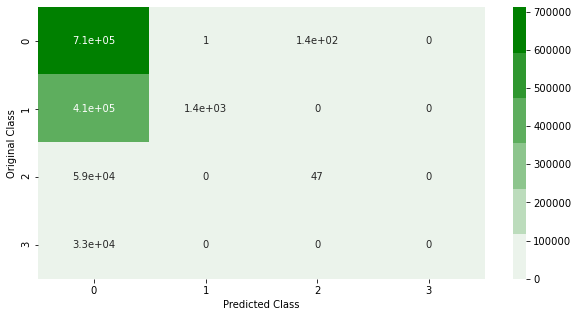

-------------------------------------------------- Precision matrix --------------------------------------------------


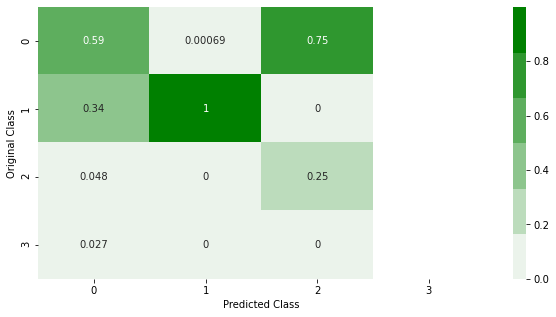

Sum of columns in precision matrix [ 1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


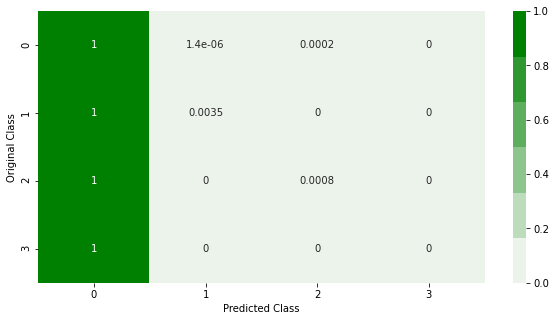

Sum of rows in recall matrix [1. 1. 1. 1.]


In [21]:
clf = pickle.load(open('lr_model.sav', 'rb'))
plot_confusion_matrix(y_cv.compute(), clf.predict(X_cv))

In [22]:
lr_test_pilots_data = []
for pilot in test_pilots:
    lr_test_pilots_data.append((pilot,'lr_model.sav','scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, lr_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("lr_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f lr_submission.csv -m "This output was generated by calibrated Logistic Regression model after featurization"

100%|██████████████████████████████████████| 1.49G/1.49G [00:29<00:00, 54.4MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/qmbHAiA.png'>

## Naive Bayes

In [23]:
var_smoothing_values = [10 ** x for x in range(-24, -16)]
cv_log_error_array=[]
for i in var_smoothing_values:
    clf = GaussianNB(var_smoothing=i)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=[0,1,2,3], eps=1e-15)
    cv_log_error_array.append(loss)
    print ('Cross validation log_loss for var_smoothing = ',i,'is',loss)
    if loss == min(cv_log_error_array):
        pickle.dump(sig_clf, open("nb_model.sav", 'wb'))

Cross validation log_loss for var_smoothing =  1e-24 is 0.9175925893971798
Cross validation log_loss for var_smoothing =  1e-23 is 0.9175925893971798
Cross validation log_loss for var_smoothing =  1e-22 is 0.9175925893971798
Cross validation log_loss for var_smoothing =  1e-21 is 0.9175925893994646
Cross validation log_loss for var_smoothing =  1e-20 is 0.9175925893992731
Cross validation log_loss for var_smoothing =  1e-19 is 0.9175925893980632
Cross validation log_loss for var_smoothing =  1e-18 is 0.9175925893992759
Cross validation log_loss for var_smoothing =  1e-17 is 0.9175925893994049


Percentage of misclassified points  41.47187506163424
-------------------------------------------------- Confusion matrix --------------------------------------------------


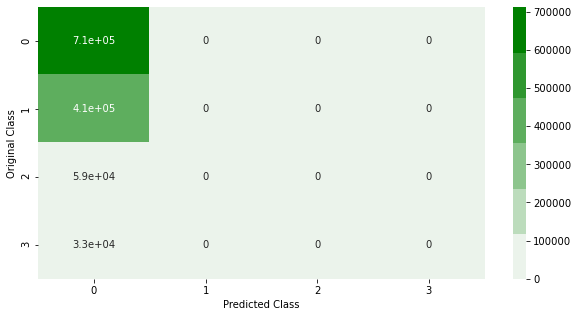

-------------------------------------------------- Precision matrix --------------------------------------------------


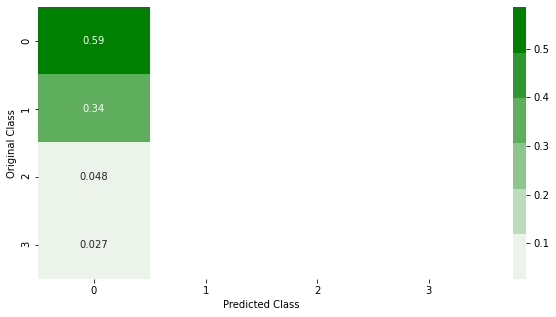

Sum of columns in precision matrix [ 1. nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


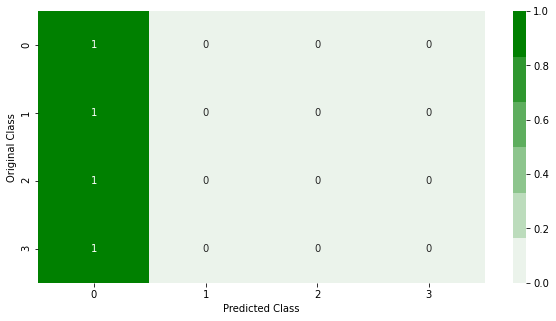

Sum of rows in recall matrix [1. 1. 1. 1.]


In [24]:
clf = pickle.load(open('nb_model.sav', 'wb'))
plot_confusion_matrix(y_cv.compute(), clf.predict(X_cv))

In [25]:
nb_test_pilots_data = []
for pilot in test_pilots:
    nb_test_pilots_data.append((pilot,'nb_model.sav','scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, nb_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("nb_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f nb_submission.csv -m "This output was generated by calibrated Naive Bayes model after featurization"

100%|██████████████████████████████████████| 1.48G/1.48G [00:28<00:00, 55.4MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/4Lb8sEr.png'>

## Decision Tree Classifier

In [26]:
max_depths = [5,10,20,50,75,100]
cv_log_error_array=[]
for i in max_depths:
    clf = DecisionTreeClassifier(max_depth=i, random_state=0, class_weight=cw)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=[0,1,2,3], eps=1e-15)
    cv_log_error_array.append(loss)
    print ('Cross validation log_loss for max_depth = ',i,'is',loss)
    if loss == min(cv_log_error_array):
        pickle.dump(sig_clf, open("dt_model.sav", 'wb'))

Cross validation log_loss for max_depth =  5 is 0.6518807455529501
Cross validation log_loss for max_depth =  10 is 0.24745791126333921
Cross validation log_loss for max_depth =  20 is 0.07081813684528972
Cross validation log_loss for max_depth =  50 is 0.0049875857076011765
Cross validation log_loss for max_depth =  75 is 0.0018004324837600767
Cross validation log_loss for max_depth =  100 is 0.0018004324837600767


Percentage of misclassified points  0.01232684886297146
-------------------------------------------------- Confusion matrix --------------------------------------------------


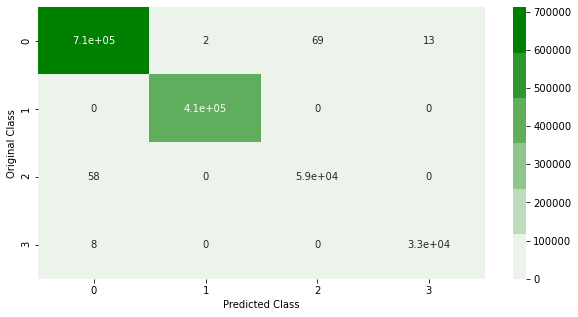

-------------------------------------------------- Precision matrix --------------------------------------------------


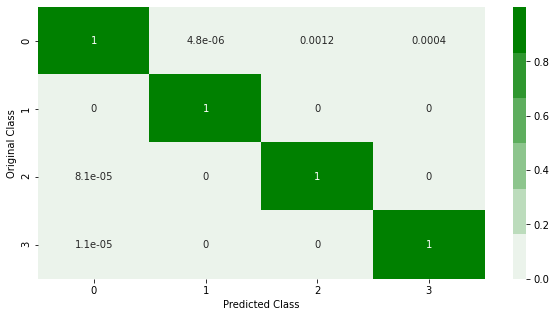

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


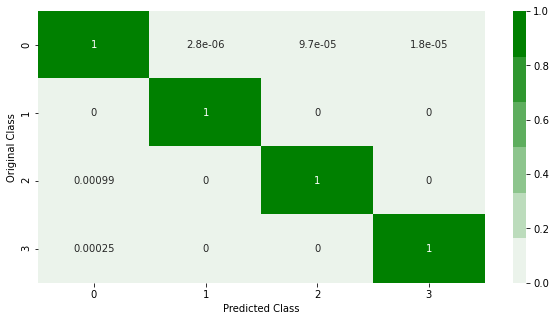

Sum of rows in recall matrix [1. 1. 1. 1.]


In [27]:
clf = pickle.load(open('dt_model.sav', 'rb'))
plot_confusion_matrix(y_cv.compute(), clf.predict(X_cv))

In [28]:
dt_test_pilots_data = []
for pilot in test_pilots:
    dt_test_pilots_data.append((pilot,'dt_model.sav','scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, dt_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("dt_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f dt_submission.csv -m "This output was generated by calibrated Decision Tree Classifier after featurization"

100%|██████████████████████████████████████| 1.56G/1.56G [00:31<00:00, 53.5MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/zJsdZK3.png'>

## Random Forest Classifier

In [29]:
r_clf=RandomForestClassifier(warm_start=True, random_state=42, n_jobs=-1, class_weight=cw)
estimators = [100,500,1000,2000,3000]
cv_log_error_array=[]
min_cv_log_loss = 1
for i in estimators:
    r_clf.set_params(**{'n_estimators':i})
    r_clf.fit(X_train,y_train)
    predict_y = r_clf.predict_proba(X_cv)
    loss = log_loss(y_cv.compute(), predict_y, labels=r_clf.classes_)
    cv_log_error_array.append(loss)
    print('Cross validation log_loss for n_estimators =',i,'is',loss)
    if loss < min_cv_log_loss:
        min_cv_log_loss = loss
        pickle.dump(r_clf, open("rf_model.sav", 'wb'))

Cross validation log_loss for n_estimators =  100 is 0.0002083465827468222
Cross validation log_loss for n_estimators =  500 is 0.00020567321914648502
Cross validation log_loss for n_estimators =  1000 is 0.00020555310076899428
Cross validation log_loss for n_estimators =  2000 is 0.00020444842854765635
Cross validation log_loss for n_estimators =  3000 is 0.00020552246712064113


Percentage of misclassified points  0.00936840513585831
-------------------------------------------------- Confusion matrix --------------------------------------------------


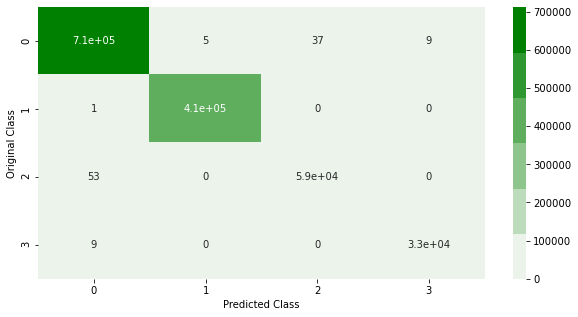

-------------------------------------------------- Precision matrix --------------------------------------------------


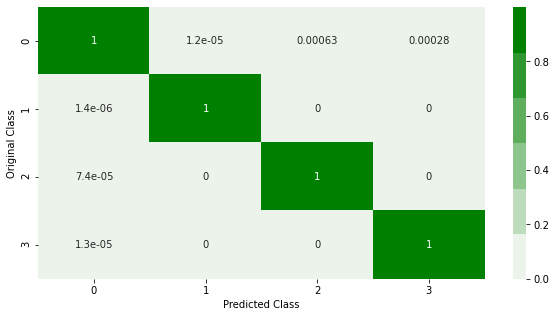

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


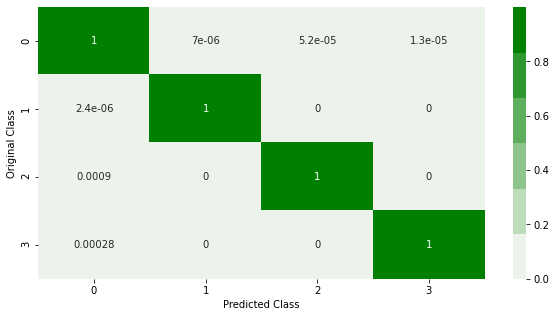

Sum of rows in recall matrix [1. 1. 1. 1.]


In [30]:
clf = pickle.load(open('rf_model.sav', 'rb'))
plot_confusion_matrix(y_cv.compute(), clf.predict(X_cv))

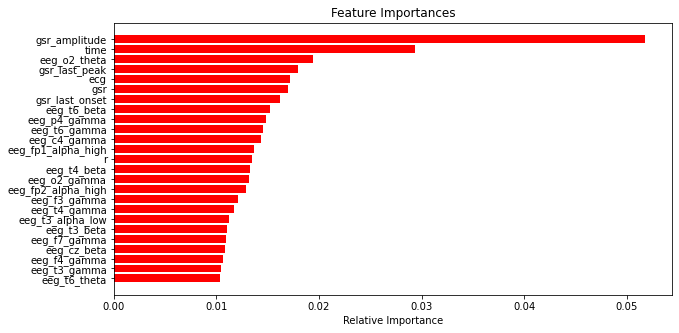

In [31]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [32]:
rf_test_pilots_data = []
for pilot in test_pilots:
    rf_test_pilots_data.append((pilot,"rf_model.sav", 'scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, rf_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("rf_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f rf_submission.csv -m "This output was generated by Random Forest model after featurization"

100%|████████████████████████████████████████| 585M/585M [00:06<00:00, 88.3MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/3DAilYG.png'>

## KNN classifier

For KNN we need to reduce the dimensionality of the model since the size of the dataset is too huge. We select top 20 features we got from Random Forest model

In [33]:
rf_model = pickle.load(open('rf_model.sav','rb'))
selector = SelectFromModel(estimator=rf_model, threshold=-np.inf, prefit=True, max_features=20)
X_train_selected = selector.transform(X_train)
X_cv_selected = selector.transform(X_cv)
pickle.dump(selector, open('selector.sav', 'wb'))
X_train_selected = dd.from_array(X_train_selected, chunksize=10000)
X_cv_selected = dd.from_array(X_cv_selected, chunksize=10000)

In [34]:
neighbors = [1,3,5,9]
cv_log_error_array=[]
for i in neighbors:
    k_cfl=KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree', n_jobs=-1)
    k_cfl.fit(X_train_selected,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid", cv='prefit')
    sig_clf.fit(X_train_selected, y_train)
    predict_y = sig_clf.predict_proba(X_cv_selected)
    loss = log_loss(y_cv, predict_y, labels=[0,1,2,3], eps=1e-15)
    cv_log_error_array.append(loss)
    print ('Cross validation log_loss for n_neighbours = ',i,'is',loss)
    if loss == min(cv_log_error_array):
        pickle.dump(sig_clf, open("knn_model.sav", 'wb'))

Cross validation log_loss for n_neighbours =  1 is 0.0018120695239619274
Cross validation log_loss for n_neighbours =  3 is 0.0015404901520025519
Cross validation log_loss for n_neighbours =  5 is 0.0017313937819627436
Cross validation log_loss for n_neighbours =  9 is 0.0022687051961786564


Percentage of misclassified points  0.02473587671836273
-------------------------------------------------- Confusion matrix --------------------------------------------------


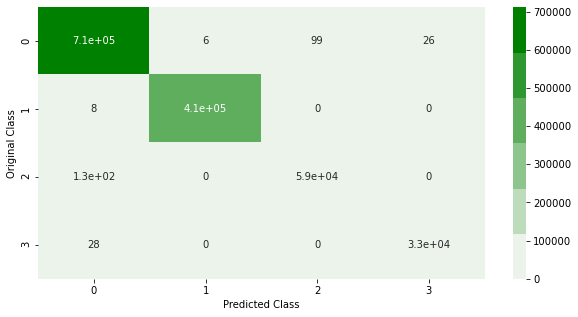

-------------------------------------------------- Precision matrix --------------------------------------------------


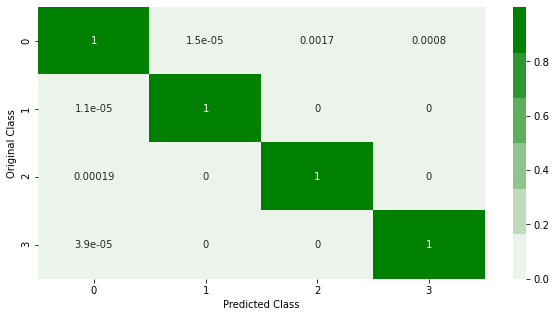

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


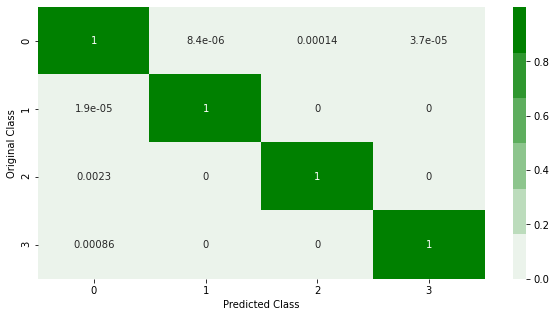

Sum of rows in recall matrix [1. 1. 1. 1.]


In [35]:
clf = pickle.load(open("knn_model.sav", 'rb'))
pred_y = clf.predict(X_cv_selected)
plot_confusion_matrix(y_cv.compute(), pred_y)

In [36]:
test_output = []
for pilot in tqdm(test_pilots):
    test_output.append(get_test_output(pilot, 'knn_model.sav', 'scaler.sav', 'selector.sav'))

test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("knn_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f knn_submission.csv -m "This output was generated by calibrated KNeighboursClassifier model after featurization and dimensionality reduction"

100%|███████████████████████████████████████| 1.60G/1.60G [00:15<00:00, 109MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/gBbtuLw.png'>

## XGBoost Classifier

In [37]:
x_cfl=XGBClassifier()

params={
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
search = RandomizedSearchCV(x_cfl,param_distributions=params,scoring='neg_log_loss',verbose=10)
search.fit(X_train,y_train)
print(search.best_params_)

{'subsample': 1, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.1}


In [38]:
x_clf = XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=0.1, max_depth=3, subsample=1)
x_clf.fit(X_train,y_train)
y_pred = x_clf.predict_proba(X_train)
loss = log_loss(y_train.compute(), y_pred)
print("Train log loss for XGBoostClassifier is "+str(loss))
y_pred = x_clf.predict_proba(X_cv)
loss = log_loss(y_cv.compute(), y_pred)
print("Cross validation log loss for XGBoostClassifier is "+str(loss))
pickle.dump(x_clf, open("xgb_model.sav",'wb'))

Train log loss for XGBoostClassifier is 0.00466007092723306
Cross validation log loss for XGBoostClassifier is 0.0048621036441629985


Percentage of misclassified points  0.0590866955498432
-------------------------------------------------- Confusion matrix --------------------------------------------------


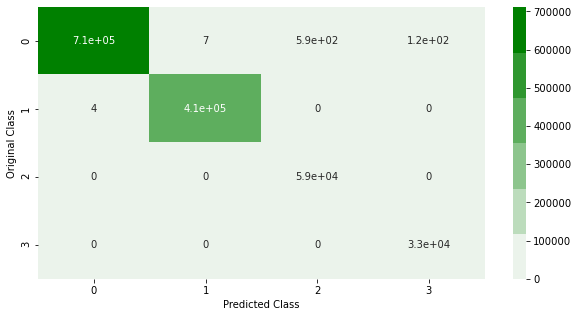

-------------------------------------------------- Precision matrix --------------------------------------------------


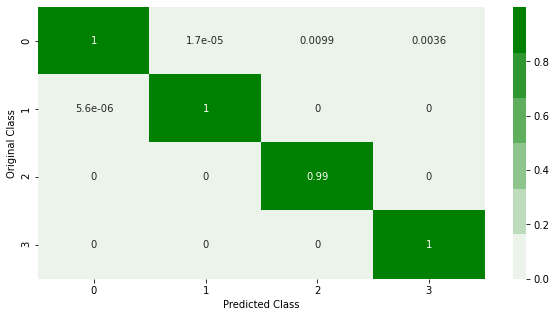

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


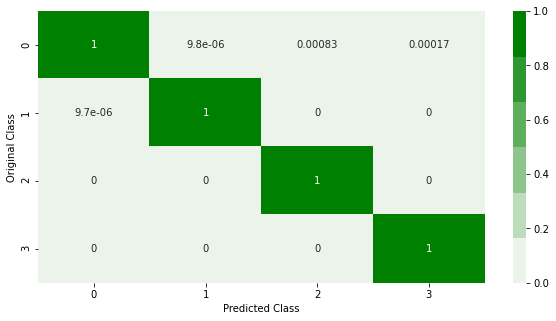

Sum of rows in recall matrix [1. 1. 1. 1.]


In [39]:
pred_y = x_clf.predict(X_cv)
plot_confusion_matrix(y_cv.compute(), pred_y)

In [40]:
xgb_test_pilots_data = []
for pilot in test_pilots:
    xgb_test_pilots_data.append((pilot,'xgb_model.sav','scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, xgb_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("xgb_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f xgb_submission.csv -m "This output was generated by XGBClassifier after featurization"

100%|██████████████████████████████████████| 1.52G/1.52G [00:17<00:00, 94.6MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/ZXA1kzq.png'>

## Adaboost Classifier

In [41]:
estimators=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in estimators:
    adb_clf=AdaBoostClassifier(n_estimators=i,random_state=33)
    adb_clf.fit(X_train,y_train)
    predict_y = adb_clf.predict_proba(X_cv)
    loss = log_loss(y_cv, predict_y, labels=adb_clf.classes_, eps=1e-15)
    cv_log_error_array.append(loss)
    print ('Cross validation log_loss for n_estimators = ',i,'is',loss)

Cross validation log_loss for n_estimators =  10 is 0.8680205800553784
Cross validation log_loss for n_estimators =  50 is 0.7381363363186694
Cross validation log_loss for n_estimators =  100 is 0.674168987835478
Cross validation log_loss for n_estimators =  500 is 0.5068583168975078
Cross validation log_loss for n_estimators =  1000 is 0.42344619142992507
Cross validation log_loss for n_estimators =  2000 is 0.4683820535626646


Percentage of misclassified points  15.10819686141992
-------------------------------------------------- Confusion matrix --------------------------------------------------


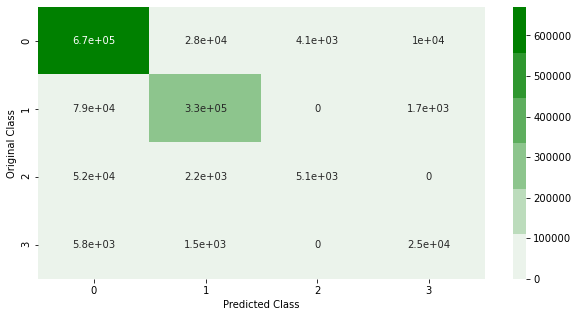

-------------------------------------------------- Precision matrix --------------------------------------------------


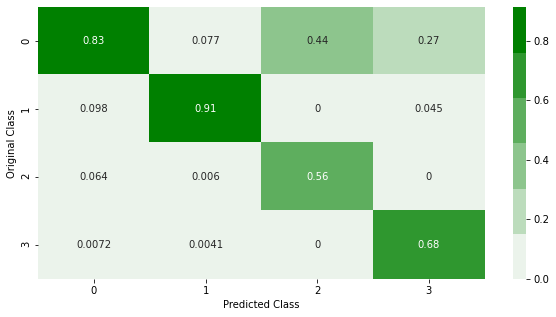

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


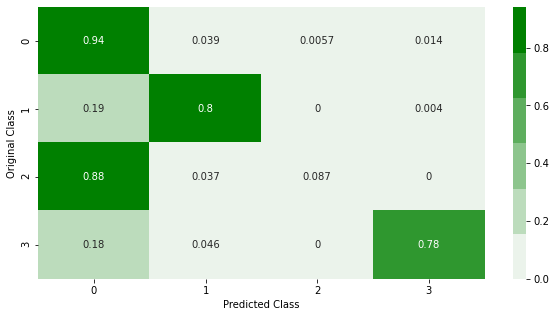

Sum of rows in recall matrix [1. 1. 1. 1.]


In [42]:
pred_y = adb_clf.predict(X_cv)
plot_confusion_matrix(y_cv.compute(), pred_y)

In [43]:
adb_test_pilots_data = []
for pilot in test_pilots:
    adb_test_pilots_data.append((pilot,'adb_model.sav', 'scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_test_output, adb_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("adb_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f adb_submission.csv -m "This output was generated by Adaboost model after featurization"

100%|███████████████████████████████████████| 1.45G/1.45G [00:14<00:00, 109MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/XiGAYeZ.png'>

## LightGBM Classifier

In [44]:
clf = lgb.LGBMClassifier(objective='multiclass',num_classes=4,metric='multi_logloss', class_weight=cw, random_state=10)
params = {'learning_rate':[0.01, 0.1, 1],
 'n_estimators':[10,25,50,100],
 'num_leaves':range(100,1000,50),
 'min_child_samples':[10,50,100,200,400],
 'colsample_bytree':[0.3,0.5,0.7],
 'subsample':[0.7,0.9,1]}
search = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='neg_log_loss', n_jobs=3, random_state=10)
print(search.best_params_)

{'num_leaves': 550, 'n_estimators': 20, 'min_child_samples': 200, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 1}


In [45]:
best_params = {
    'num_leaves': 550,
    'n_estimators': 25,
    'min_child_samples':200,
    'learning_rate': 0.1,
    'colsample_bytree': 0.3,
    'subsample':1
}
lgb_clf = lgb.LGBMClassifier(boosting_type='goss',objective='multiclass',num_classes=4, random_state=10, class_weight=cw, importance_type='gain', **best_params)
lgb_clf.fit(X_train,y_train)
y_pred = lgb_clf.predict_proba(X_train)
loss = log_loss(y_train.compute(), y_pred)
print("Train log loss for LGBMClassifier is "+str(loss))
y_pred = lgb_clf.predict_proba(X_cv)
loss = log_loss(y_cv.compute(), y_pred)
print("Cross validation log loss for LGBMClassifier is "+str(loss))
pickle.dump(lgb_clf, open("lgb_model.sav",'wb'))

Train log loss for LGBMClassifier is 0.03071898993483836
Cross validation log loss for LGBMClassifier is 0.03073719843977904


Percentage of misclassified points  0.1410191509923935
-------------------------------------------------- Confusion matrix --------------------------------------------------


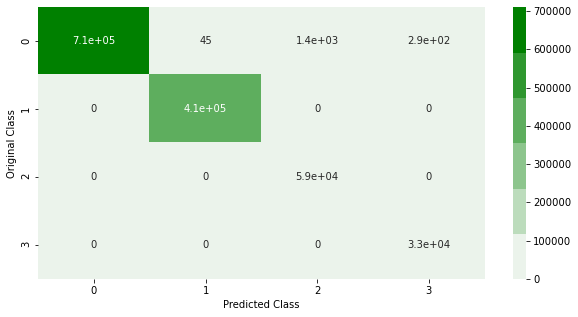

-------------------------------------------------- Precision matrix --------------------------------------------------


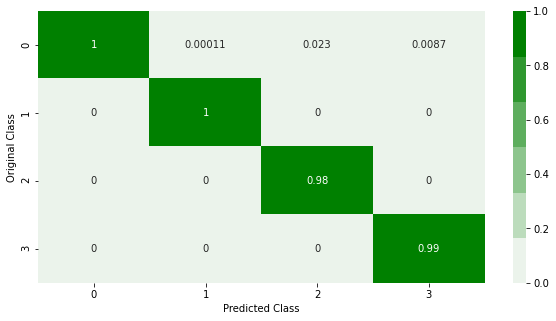

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


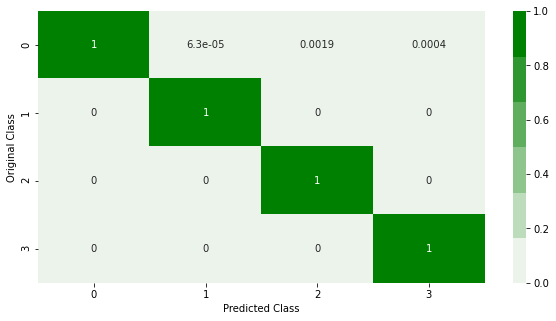

Sum of rows in recall matrix [1. 1. 1. 1.]


In [46]:
plot_confusion_matrix(y_cv.compute(), lgb_clf.predict(X_cv))

In [46]:
lgb_test_pilots_data = []
for pilot in test_pilots:
    lgb_test_pilots_data.append((pilot,'lgb_model.sav','scaler.sav'))
if __name__ == '__main__':
    with Pool(processes=6) as pool:
        test_output = pool.starmap(get_test_output, lgb_test_pilots_data)

In [47]:
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("lgb_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f lgb_submission.csv -m "This output was generated by LightGBM model after featurization"

100%|██████████████████████████████████████| 1.49G/1.49G [00:29<00:00, 54.5MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/KfD3z69.png'>

## CatBoost Classifier

For CatBoost Classifier, we are reverting the one-hot encoded features to categorical features

In [48]:
X_train = X_train.compute()
X_cv = X_cv.compute()
X_train['crew'] = crew_ohe.inverse_transform(X_train[crew_ohe_features])
X_cv['crew'] = crew_ohe.inverse_transform(X_cv[crew_ohe_features])
X_train.drop(crew_ohe_features, axis=1, inplace=True)
X_cv.drop(crew_ohe_features, axis=1, inplace=True)
y_train = y_train.compute()
y_cv = y_cv.compute()
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
clf = CatBoostClassifier(loss_function='MultiClass', random_state=33, class_weights=cw)
params = {'learning_rate':[0.01, 0.05, 0.1, 0.5],
 'n_iterations':[100,500,1000,2000],
 'max_depth':[1,3,5,10]}
search = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='neg_log_loss', n_jobs=3, random_state=10)
print(search.best_params_)

{'n_iterations': 500, 'max_depth': 3, 'learning_rate': 0.1}


Train log loss for CatBoostClassifier is 0.22513086228263166
Cross validation log loss for CatBoostClassifier is 0.22537039797341504
Percentage of misclassified points  7.084486578526958
-------------------------------------------------- Confusion matrix --------------------------------------------------


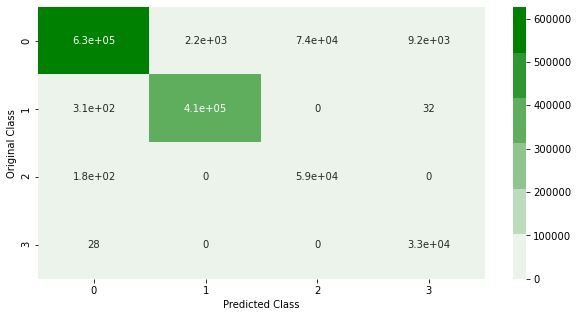

-------------------------------------------------- Precision matrix --------------------------------------------------


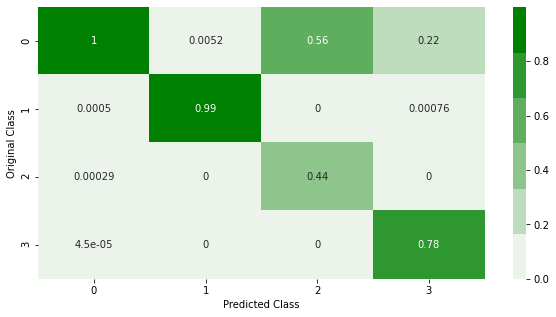

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


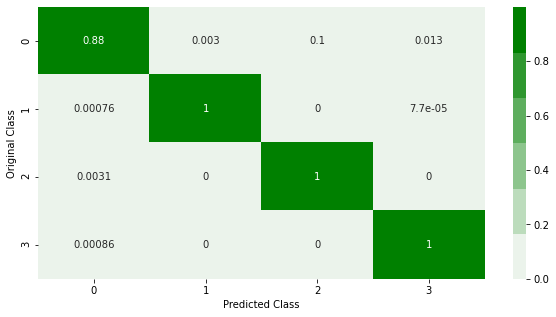

Sum of rows in recall matrix [1. 1. 1. 1.]


In [49]:
catb_clf = CatBoostClassifier(iterations=500, depth=3, learning_rate=0.1, loss_function='MultiClass', random_state=33, class_weights=cw)
catb_clf.fit(X_train, y_train,cat_features=categorical_features_indices,verbose=0)
y_pred = catb_clf.predict_proba(X_train)
loss = log_loss(y_train, y_pred)
print("Train log loss for CatBoostClassifier is "+str(loss))
y_pred = catb_clf.predict_proba(X_cv)
loss = log_loss(y_cv, y_pred)
print("Cross validation log loss for CatBoostClassifier is "+str(loss))
pickle.dump(catb_clf, open('catb_model.sav','wb'))
plot_confusion_matrix(y_cv, catb_clf.predict(X_cv))

In [50]:
def get_catboost_test_output(pilot, model_file, scaler_file=None):
    # Function to generate output for each pilot in given test data
    X_test = pd.read_parquet("test_new_features/"+str(pilot)+".gzip")
    df_pred = pd.DataFrame()
    df_pred['id'] = X_test['id']
    X_test = X_test.drop(['id'], axis=1)
    if scaler_file:
        features = X_test.columns
        crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
        crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
        numerical_features = [feature for feature in features if feature not in crew_ohe_features+['seat']]
        scaler = pickle.load(open('scaler.sav', 'rb'))
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])
        X_test['crew'] = crew_ohe.inverse_transform(X_test[crew_ohe_features])
        X_test.drop(crew_ohe_features, axis=1, inplace=True)
    X_test = reduce_mem_usage(X_test)
    model = pickle.load(open(model_file, 'rb'))
    y_pred = model.predict_proba(X_test)
    df_pred['A'] = y_pred[:,0]
    df_pred['B'] = y_pred[:,3]
    df_pred['C'] = y_pred[:,1]
    df_pred['D'] = y_pred[:,2]
    return df_pred

In [51]:
catb_test_pilots_data = []
for pilot in test_pilots:
    catb_test_pilots_data.append((pilot,'catb_model.sav', 'scaler.sav'))

with Pool(processes=6) as pool:
    test_output = pool.starmap(get_catboost_test_output, catb_test_pilots_data)
        
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("catb_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f catb_submission.csv -m "This output was generated by Catboost model"

100%|██████████████████████████████████████| 1.52G/1.52G [00:17<00:00, 93.6MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/zTGJ0ow.png'>

# Results

| Model | CV log loss | Kaggle public score | Kaggle private score | Public leaderboard position | Private leaderboard position |
|:-|---|---|---|---|---|
| LogisticRegression | 0.8959 | 3.45141 | 3.15338 | 167 | 150 |
| GaussianNB | 0.9176 | 0.63480 | 0.68650 | 109 | 43 |
| DecisionTreeClassifier | 0.0018 | 2.50777 | 3.49236 | 166 | 152 |
| RandomForestClassifier | 0.000204 | 0.36600 | 0.56395 | 18 | 11 |
| KNeighboursClassifier | 0.00154 | 4.35032 | 4.61351 | 168 | 153 |
| XGBClassifier | 0.0049 | 0.39630 | 0.80004 | 28 | 89 |
| AdaBoostClassifier | 0.4234 | 1.30048 | 1.31386 | 143 | 128 |
| LightGBMClassifier | 0.03076 | 0.34651 | 0.61582 | 12 | 17 |
| CatBoostClassifier | 0.2254 | 0.54158 | 0.94352 | 73 | 114 |

## Conclusion

RandomForestClassifier model gives the best private score whereas LightGBMClassifier model gives the best public score on Kaggle